In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import ndimage as ndi
import os
import glob
import time
import pickle
import matplotlib.pyplot as plt
import re
import random
import seaborn as sns

In [2]:
import skimage.io as io
from skimage import feature
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist

In [3]:
# Pickling functions
def pickle_it(data, filename):
    with open(filename, "wb") as picklefile:
        pickle.dump(data, picklefile)

def load_pickle(filename):
    with open(filename, "rb") as picklefile: 
        return pickle.load(picklefile)

obtain all training set image file locations with glob. Sorted glob to match the sorted ID's later.

In [5]:
glob = sorted(glob.glob("./train/*.jpg"))

In [6]:
def get_imagefiles(glob):
    imagelist = []
    for imagefile in glob:
        bee = io.imread(imagefile)
        imagelist.append(bee)   
    return imagelist

In [7]:
beetrainset = get_imagefiles(glob)

beetrainset reads in all images in training set and returns it as an array

In [8]:
def get_beeID_list(glob):
    idlist = []
    for imagefile in glob:
        beeID = re.findall(r'\d+',imagefile)
        #beeID is a list object
        idlist.append(beeID[0])
    return list(set(idlist))

In [9]:
beeIDs = get_beeID_list(glob)

beeID list to be used to pick random image out of folder.

In [10]:
pickle_it(beeIDs,'beeIDs.pkl')
pickle_it(beetrainset,'beetrainset.pkl')



In [11]:
bee_ID = load_pickle('beeIDs.pkl')
bee_train = load_pickle('beetrainset.pkl')

#create bee dictionary beeID : imagearray

In [12]:
#sorted bee_ID to align IDs with previously sorted image arrays.
beedict = dict(zip(sorted(bee_ID), bee_train))

In [13]:
def show_randbee(beedict, beeIDlist):
    for ID in random.sample(beeIDlist,1):
        rbee = beedict[ID]
        randombee = io.imshow(beedict[ID])
        print 'BeeID: ',ID
        return (randombee, rbee)

show_randbee returns 2 things: image, array of random bee

BeeID:  4213


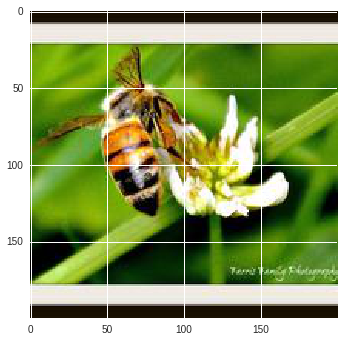

In [68]:
randombee,rbee = show_randbee(beedict,bee_ID)

In [69]:
rbee

array([[[25, 16,  0],
        [25, 16,  0],
        [25, 16,  0],
        ..., 
        [25, 16,  0],
        [25, 16,  0],
        [25, 16,  0]],

       [[22, 13,  0],
        [22, 13,  0],
        [22, 13,  0],
        ..., 
        [22, 13,  0],
        [22, 13,  0],
        [22, 13,  0]],

       [[23, 14,  0],
        [23, 14,  0],
        [23, 14,  0],
        ..., 
        [23, 14,  0],
        [23, 14,  0],
        [23, 14,  0]],

       ..., 
       [[24, 15,  0],
        [24, 15,  0],
        [24, 15,  0],
        ..., 
        [24, 15,  0],
        [24, 15,  0],
        [24, 15,  0]],

       [[23, 14,  0],
        [23, 14,  0],
        [23, 14,  0],
        ..., 
        [23, 14,  0],
        [23, 14,  0],
        [23, 14,  0]],

       [[26, 17,  2],
        [26, 17,  2],
        [26, 17,  2],
        ..., 
        [26, 17,  2],
        [26, 17,  2],
        [26, 17,  2]]], dtype=uint8)

#image preprocessing

In [70]:
def hist_equalizer(img_array):
    gray = rgb2gray(img_array)
    eq_array = equalize_hist(gray)
    eq_img = io.imshow(eq_array)
    return(eq_img, eq_array)

In [71]:
def canny_edge(img_array, sig):
    """
    default sigma is 1
    """
    gray = rgb2gray(img_array)
    canny_array = np.invert(feature.canny(gray, sigma=sig))
    canny_img = io.imshow(canny_array)
    return (canny_img, canny_array)

In [72]:
def binarize(img_array):
    gray = rgb2gray(img_array)
    bi_array = np.where(gray>np.mean(gray), 1.0, 0.0)
    bi_img = io.imshow(bi_array)
    return (bi_img, bi_array)

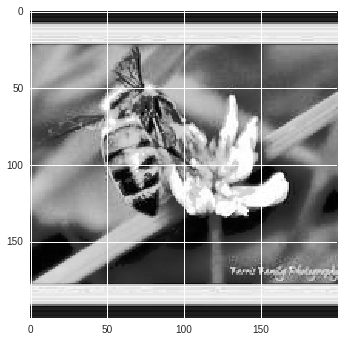

In [73]:
eq_img, eq_array = hist_equalizer(rbee)

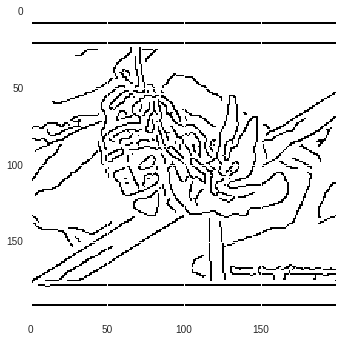

In [74]:
canny_img, canny_array = canny_edge(rbee,1.4)

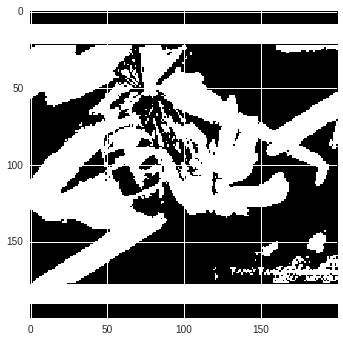

In [75]:
bi_img, bi_array = binarize(rbee)

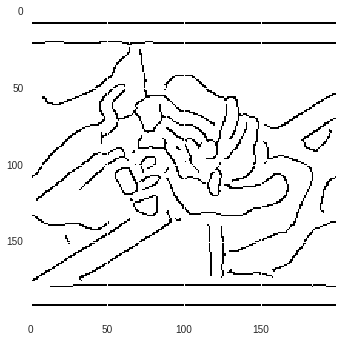

In [76]:
bi_eq_img, bi_eq_array = canny_edge(eq_array, 3)

In [77]:
def window(img_array):
    gray = rgb2gray(img_array)
    l_x, l_y = gray.shape[0], gray.shape[1]
    X,Y = np.ogrid[:l_x, :l_y]
    outerdisk_mask = (X - l_x / 2)**2 + (Y - l_y / 2)**2 > (l_x / 2)**2
    gray[outerdisk_mask] = 0
    window_array = gray
    window_img = io.imshow(gray)
    return window_img, window_array

Essentially this mask cuts out the corners of the picture. There may be instances where this would cut off a piece of the bee.

(200, 200)


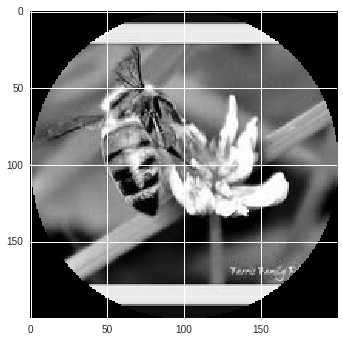

In [78]:
window_img, window_array = window(rbee)
print window_array.shape

In [62]:
def gridsplit(array,rows,cols):
    for row in np.array_split(array,rows):
        for piece in np.array_split(row,cols,axis = 1):
            io.imshow(piece)
            io.show()

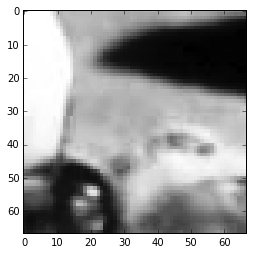

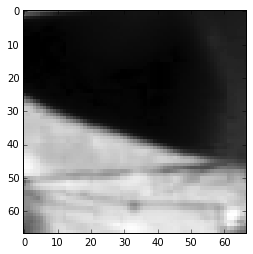

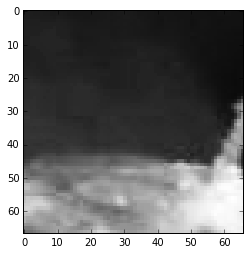

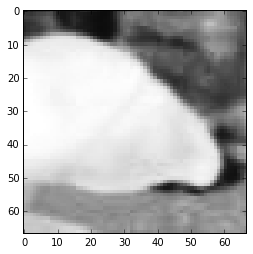

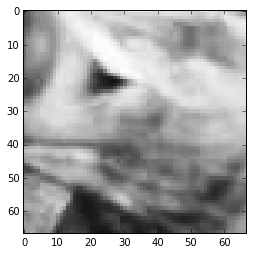

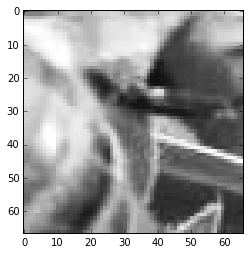

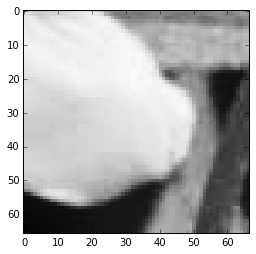

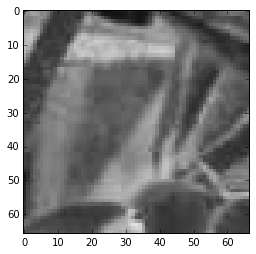

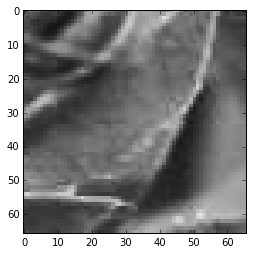

None


In [25]:
print gridsplit(eq_array,3,3)


In [79]:
def extract_rgb_info(rgb, ax=None):
    """Extract color statistics as features:
        - pixel values (flattened)
        - X, Y sums per channel
        - percentiles per channel
        - percentile diffs per channel

        Plots if ax is passed
    """
    # toss alpha if it exists
    if rgb.shape[2] == 4:
        rgb = rgb[:, :, :3]

    # start with raw pixel values as features
    features = [rgb.flatten()]

    # add some basic statistics on the color channels (R, G, B)
    for channel in range(3):
        this_channel = rgb[:, :, channel].astype(np.float)
        sums = np.hstack([this_channel.sum(),
                          this_channel.sum(axis=0),
                          this_channel.sum(axis=1)])

        # percentiles
        ps = [1, 3, 5, 10, 50, 90, 95, 97, 99]
        percentiles = np.array(np.percentile(this_channel, ps))
        diff = percentiles[-4:] - percentiles[:4]
        
        # plot if we have been passed an axis
        if ax is not None:
            channel_name = ['r', 'g', 'b'][channel]       
            sns.kdeplot(this_channel.flatten(),
                        ax=ax,
                        label=channel_name,
                        color=channel_name)
            ax.set_title("Color channels")

        
        # store the features for this channel
        
        features += [sums, percentiles, diff]
        
    # return all the color features as a flat array
    return np.hstack(features).flatten()


In [80]:
#randombee,rbee = show_randbee(beedict,bee_ID)





array([  25.,   16.,    0., ...,  230.,  237.,  254.])

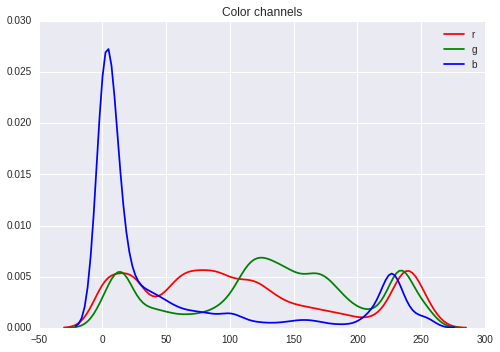

In [81]:
extract_rgb_info(rbee, ax=plt.gca())

In [13]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

import os
import Image
import ImageOps
import numpy as np
path = '/Users/oli/Dropbox/Photos/Sample Album/'
imgs = os.listdir(path)


# Creating images (fake only 3 real images) just for demonstration
PIXELS = 96
X = np.zeros((100,3, PIXELS, PIXELS), dtype='float32')
y = np.zeros(100)
for i in range(0,100):
    d = i % 3
    y[i] = d
    img = Image.open(path + imgs[d])
    img = ImageOps.fit(img, (PIXELS, PIXELS), Image.ANTIALIAS)
    img = np.asarray(img, dtype = 'float32') / 255.
    img = img.transpose(2,0,1).reshape(3, PIXELS, PIXELS)
    X[i] = img


net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('hidden2', layers.DenseLayer),

        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 3, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    hidden1_num_units=500,
    hidden2_num_units=50,
    output_num_units=10, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=100,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
        )

X = X.astype(np.float32)
y = y.astype(np.int32)
print(X.shape)
print(y.shape)
net1.fit(X, y)

ImportError: No module named lasagne

In [18]:
rbee[0][0][2]

IndexError: invalid index to scalar variable.

In [83]:
 hog_features = hog(eq_array,
                       orientations=12,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(1, 1),
                       visualise=demo)

NameError: name 'hog' is not defined